##### installing packages

In [1]:
!pip install transformers torch evaluate tqdm dataset

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.3 MB/s eta 0:00:00
  Attempting uninstall: sqlalchemy
    Found existing installation: SQLAlchemy 2.0.37
    Uninstalling SQLAlchemy-2.0.37:
      Successfully uninstalled SQLAlchemy-2.0.37
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10

#### Loading packages

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import re
import pandas as pd
import string
import numpy as np
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import torch, codecs, random
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from evaluate import load as load_metric
from google.colab import output
import matplotlib.pyplot as plt
from typing import List, Dict, Any
from transformers import PreTrainedTokenizer
from torch.optim import Optimizer

output.enable_custom_widget_manager()

from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


## Data Preprocessing

In [3]:
df = pd.read_csv("/content/drive/MyDrive/Tweets_5K.csv")

df.head()

,textID,text,sentiment
0,cb774db0d1,"I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,negative
2,088c60f138,my boss is bullying me...,negative
3,9642c003ef,what interview! leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...",negative


In [4]:
df['sentiment'].value_counts()

,count
sentiment,
neutral,2023
positive,1592
negative,1385


In [5]:
df['sentiment'] = df['sentiment'].replace({'neutral': 0,
                                           'positive': 1,
                                           'negative': -1})

raw_tweets = df['text'].to_list()
labels = df['sentiment'].to_list()


# X = dataset['text'].to_list()
# y = dataset['sentiment'].map({'negative': 0, 'neutral': 1, 'positive': 2}).to_list()

In [6]:
# Removing whitespaces from the tweets

basic_preproc_tweets = [a.split() for a in raw_tweets]

basic_preproc_tweets[:3]

[['I`d', 'have', 'responded,', 'if', 'I', 'were', 'going'],
 ['Sooo', 'SAD', 'I', 'will', 'miss', 'you', 'here', 'in', 'San', 'Diego!!!'],
 ['my', 'boss', 'is', 'bullying', 'me...']]

In [7]:
#Featurize - bag of words

tweet_dicts = [dict(Counter(tweet)) for tweet in basic_preproc_tweets]
vectorizer = DictVectorizer(sparse=False)
X = vectorizer.fit_transform(tweet_dicts)
vocabulary = vectorizer.get_feature_names_out()

print("Vocabulary:\n", vocabulary)

Vocabulary:
 ['!' '!!' '!!!' ... 'ï¿½4.80' 'ï¿½anisalovesu' 'ï¿½you']


In [8]:
df_bow = pd.DataFrame(X, columns=vocabulary)
df_bow.head(5)

,!,!!,!!!,!!!!,!!!!!,!!!!!!!!,!!my,!+,!1!!,#,...,zombies?',{this,{{{HUGS}}},~,ï¿½,ï¿½1.50,ï¿½2,ï¿½4.80,ï¿½anisalovesu,ï¿½you
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# Lowercasing

lowercased_tweets = [[a.lower() for a in j] for j in basic_preproc_tweets]
lowercased_tweets[:5]

[['i`d', 'have', 'responded,', 'if', 'i', 'were', 'going'],
 ['sooo', 'sad', 'i', 'will', 'miss', 'you', 'here', 'in', 'san', 'diego!!!'],
 ['my', 'boss', 'is', 'bullying', 'me...'],
 ['what', 'interview!', 'leave', 'me', 'alone'],
 ['sons',
  'of',
  '****,',
  'why',
  'couldn`t',
  'they',
  'put',
  'them',
  'on',
  'the',
  'releases',
  'we',
  'already',
  'bought']]

In [10]:
# Lemmatization

import nltk
nltk.download("wordnet")

lem = WordNetLemmatizer()
lem_tweets = [[lem.lemmatize(a) for a in j] for j in lowercased_tweets]

lem_tweets[:3]

[nltk_data] Downloading package wordnet to /root/nltk_data...


[['i`d', 'have', 'responded,', 'if', 'i', 'were', 'going'],
 ['sooo', 'sad', 'i', 'will', 'miss', 'you', 'here', 'in', 'san', 'diego!!!'],
 ['my', 'bos', 'is', 'bullying', 'me...']]

In [11]:
# Removing punctuations and extra white spaces

remove_punctuations_tweets = [[re.sub(r'\W+', '', a) for a in j if a] for j in lem_tweets]

In [12]:
# Removing stop words
nltk.download("stopwords")

print(stopwords.words('english'))

stop_words = set(stopwords.words('english'))

remove_stop_words_tweets = [[a for a in j if a not in stop_words] for j in remove_punctuations_tweets]

print("Tweets without Stop Words:")
print(remove_stop_words_tweets)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [13]:
# Replace numbers with NUM

replace_numbers_tweets = [['NUM' if a.isdigit() else a for a in j] for j in remove_stop_words_tweets]
replace_numbers_tweets[:3]

[['id', 'responded', 'going'],
 ['sooo', 'sad', 'miss', 'san', 'diego'],
 ['bos', 'bullying']]

In [14]:
#Use only the top 1000 most frequent words, and replace the rest with OOV (1001 columns final)

all_words_list = [a for j in replace_numbers_tweets for a in j]
all_words_list

count_words = Counter(all_words_list)
len(all_words_list)

count_words.most_common(10)

top_freq_words = {a for a, _ in count_words.most_common(1000)}
tweets_with_most_freq_words_final = [[a if a in top_freq_words else 'OOV' for a in j] for j in replace_numbers_tweets]


In [15]:
tweet_dicts = [dict(Counter(tweet)) for tweet in tweets_with_most_freq_words_final]
vectorizer_1 = DictVectorizer(sparse=False)
X_final = vectorizer_1.fit_transform(tweet_dicts)
vocabulary_final = vectorizer_1.get_feature_names_out()

print("Vocabulary:\n", vocabulary_final)

df = pd.DataFrame(X_final, columns=vocabulary_final)
df.head()

Vocabulary:
 ['' '1st' '2day' ... 'youve' 'yum' 'yummy']


,,1st,2day,3d,4th,NUM,OOV,_,able,absolutely,...,yes,yesterday,yet,youll,young,youre,youtube,youve,yum,yummy
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Splitting the data

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_final,labels,test_size = 0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)

(4000, 1001)
(1000, 1001)


## Baseline Model


Base Line Classifier Model - that contains frequent category. For that we create a list that contains most frequent class and compare it with *y_pred_baseline*

In [17]:
frequency_count = Counter(y_train)
print(frequency_count)


most_frequent_class = frequency_count.most_common(1)[0][0]
print(most_frequent_class)

y_pred_baseline = [most_frequent_class] * len(y_test)

baseline_model_accuracy_score = accuracy_score(y_test, y_pred_baseline)
print(f"Baseline Classifier Accuracy: {baseline_model_accuracy_score:.4f}")

Counter({0: 1616, 1: 1298, -1: 1086})
0
Baseline Classifier Accuracy: 0.4070


## Naive Bayes

In [18]:
naive_bayes_model = MultinomialNB(alpha=1.0)

# We use alpha parameter to add add-1 smoothing

naive_bayes_model.fit(X_train,y_train)

y_pred = naive_bayes_model.predict(X_test)

nb_accuracy = accuracy_score(y_test,y_pred)
print(f"Model Accuracy - Naive Bayes: {nb_accuracy:.4f}")

Model Accuracy - Naive Bayes: 0.5840


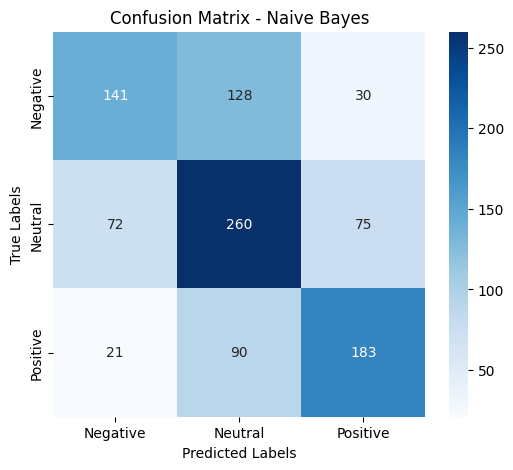

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)

class_labels = ['Negative', 'Neutral', 'Positive']

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Naive Bayes')
plt.show()


## Logistic Regression

In [20]:
lr_model = LogisticRegression(max_iter = 200,
                             multi_class = 'ovr')

lr_model.fit(X_train,y_train)
y_pred_lr = lr_model.predict(X_test)

lr_model_accuracy = accuracy_score(y_test, y_pred_lr)
print(f"Model Accuracy - Logistic Regression: {lr_model_accuracy:.4f}")

Model Accuracy - Logistic Regression: 0.6070


In [21]:
frequency_count = Counter(y_train)
most_frequent_class = frequency_count.most_common(1)[0][0]
y_pred_baseline = [most_frequent_class] * len(y_test)

baseline_model_accuracy_score = accuracy_score(y_test, y_pred_baseline)
print(f"Baseline Classifier Accuracy: {baseline_model_accuracy_score:.4f}")

print(f"The Logistic Regression model is better from baseline with an improvement of {lr_model_accuracy - baseline_model_accuracy_score:.4f}")

Baseline Classifier Accuracy: 0.4070
The Logistic Regression model is better from baseline with an improvement of 0.2000


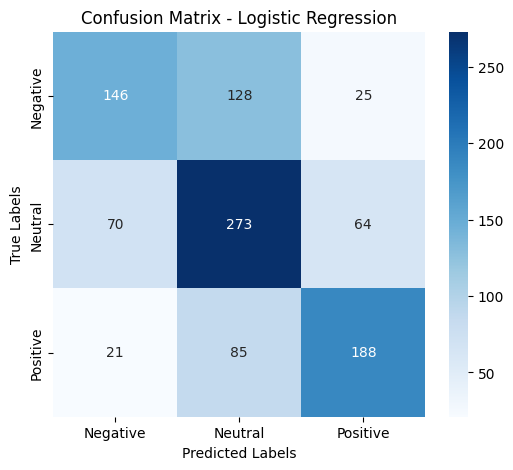

In [22]:
cm_lr = confusion_matrix(y_test, y_pred_lr)

class_labels = ['Negative', 'Neutral', 'Positive']

plt.figure(figsize=(6, 5))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

In [23]:
if lr_model_accuracy > nb_accuracy:
    print(f"The LR model is better from NB with a difference of: {(lr_model_accuracy - nb_accuracy) * 100} %")
else:
    print(f"The NB model is better from LR with a difference of {(nb_accuracy - lr_model_accuracy)*100} %")

The LR model is better from NB with a difference of: 2.300000000000002 %


# BERT Fine-tuning for Sentiment Classification

In [24]:
assert torch.cuda.is_available()

In [26]:
dataset = pd.read_csv("/content/drive/MyDrive/Tweets_5K.csv")

#### Data Preparation

In [28]:
tweets_with_most_freq_words_final[:3]

[['id', 'OOV', 'going'], ['sooo', 'sad', 'miss', 'san', 'OOV'], ['bos', 'OOV']]

In [29]:
X = dataset['text'].to_list()
y = dataset['sentiment'].map({'negative': 0, 'neutral': 1, 'positive': 2}).to_list()

In [30]:
X[:3]

[' I`d have responded, if I were going',
 ' Sooo SAD I will miss you here in San Diego!!!',
 'my boss is bullying me...']

In [31]:

# split X and y into a train/validation/test set, use fixed-indices (3000/1000/1000)
trainset, trainlabs = tweets_with_most_freq_words_final[:3000], y[:3000]
valset, vallabs = tweets_with_most_freq_words_final[3000:4000], y[3000:4000]
testset, testlabs = tweets_with_most_freq_words_final[4000:], y[4000:]

print(f"Training examples: {len(trainset)}")
print(f"Validation examples: {len(valset)}")
print(f"Test examples: {len(testset)}")

Training examples: 3000
Validation examples: 1000
Test examples: 1000


Preparing the dataset as BERT requires [CLS] and [SEP] tokens.

In [32]:
class TweetDataset(torch.utils.data.Dataset):
  """
  A PyTorch Dataset for our tweets that can be iterated through using __getitem__
  """
  def __init__(self, tweets : List[str], sentiments : List[int], tokenizer : PreTrainedTokenizer) -> None:
    """
    Initializes the TweetDataset from a list of tweets, their corresponding sentiments, and a tokenizer.

    Attributes
    ----------
    tweets : List[str]
      A list of tweets, where each tweet is a string
    sentiments: List[int]
      A list of sentiments represented as integers ('negative': 0, 'neutral': 1, 'positive': 2)
    tokenizer : PreTrainedTokenizer
      Any PreTrainedTokenizer from HuggingFace can be used to encode the string inputs for a model
    """
    self.tweets = tweets
    self.sentiments = sentiments
    self.tokenizer = tokenizer
    self.max_len = tokenizer.model_max_length

  def __len__(self) -> int:
    """
    Returns the number of tweets in the dataset.
    """
    return len(self.tweets)

  def __getitem__(self, index : int) -> Dict[str, Any]:
    """
    Retrieve a preprocessed data item from the dataset at the specified index.
    This is called when iterating through a TweetDataset

    Parameters:
    ----------
    index : int
        The index of the data item to retrieve.

    Returns:
    -------
    Dict[str, Any]
        A dictionary containing the preprocessed data for the given index.
        The dictionary includes the following keys:
        - 'input_ids': Encoded input IDs for the tweet.
        - 'attention_mask': Attention mask for the tweet.
        - 'labels': Sentiment label as a PyTorch tensor.
    """
    tweet = str(self.tweets[index])
    sentiments = self.sentiments[index]

    encoded_tweet = self.tokenizer.encode_plus(
      tweet,
      add_special_tokens      = True,
      max_length              = self.max_len,
      return_token_type_ids   = False,
      return_attention_mask   = True,
      return_tensors          = "pt",
      padding                 = "max_length",
      truncation              = True
    )

    return {
      'input_ids': encoded_tweet['input_ids'][0],
      'attention_mask': encoded_tweet['attention_mask'][0],
      'labels': torch.tensor(sentiments, dtype=torch.long)
    }

### Tokenizer and dataloader

In [33]:
from transformers import AutoTokenizer
from torch.utils.data import DataLoader

# tokenizer argument of the TweetDataset
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

# TweetDataset objects
train_dataset = TweetDataset(trainset,trainlabs,tokenizer)
validation_dataset = TweetDataset(valset,vallabs,tokenizer)
test_dataset = TweetDataset(testset,testlabs,tokenizer)

# now construct DataLoader objects from the TweetDataset objects
# remember that the TweetDataset class is a child class of torch.utils.data.Dataset

train_dataloader = DataLoader(train_dataset,batch_size=32, shuffle = True)
validation_dataloader = DataLoader(validation_dataset,batch_size=32, shuffle = False)
test_dataloader = DataLoader(test_dataset,batch_size=32, shuffle = False)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

### Baseline Untrained Model

In [34]:
from transformers import AutoConfig, AutoModelForSequenceClassification

# getting the distilbert-base-uncased config...
config = AutoConfig.from_pretrained("distilbert-base-uncased", num_labels=3)

untrained_model = AutoModelForSequenceClassification.from_config(config)

In [35]:
# Evaluating model predictions on untrained model

# For any parameter named 'device', pass the following variable:
device = torch.device("cuda")

# Loading the model onto the device
untrained_model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [36]:
def update_metrics(metrics, predictions: torch.Tensor, labels: torch.Tensor) -> None:
  """
  Update a list of metrics with new predictions and labels

  Parameters:
  -----------
  metrics : List[Metric]
      List of metrics.
  predictions : torch.Tensor
      Tensor of predictions of shape (batch_size, ...)
  labels : torch.Tensor
      Tensor of labels of shape (batch_size, ...)

  Returns:
  --------
  None
  """
  for metric in metrics:
    metric.add_batch(predictions=predictions, references=labels)

def evaluate(model: torch.nn.Module, test_dataloader: torch.utils.data.DataLoader,
             device: torch.device, metric_strs: List[str]) -> Dict[str, float]:
  """
  Evaluate a PyTorch Model

  Parameters:
  -----------
  model : torch.nn.Module
      The model to be evaluated.
  test_dataloader : torch.utils.data.DataLoader
      DataLoader containing testing examples.
  device : torch.device
      The device that the evaluation will be performed on.
  metric_strs : List[str]
      The names of Hugging Face metrics to use.

  Returns:
  --------
  Dict[str, float]
      Dictionary of metric names mapped to their values.
  """
  # load metrics
  metrics = [load_metric(x) for x in metric_strs] # could add more here!
  model.eval()

  # progress bars :)
  progress_bar = tqdm(range(len(test_dataloader)))

  with torch.no_grad():
    for batch in test_dataloader:

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids = input_ids, attention_mask = attention_mask)
        logits = outputs.logits

        predictions = torch.argmax(logits, dim = -1).detach()

        update_metrics(metrics, predictions, labels)

        progress_bar.update(1)

  computed = {}
  for m in metrics:
    computed = {**computed, **m.compute()}

  return computed

#### Baseline performance

In [37]:
from scipy.stats import describe
from math import sqrt

def make_plots(perfs: List[float], names: List[str]) -> None:
  """
  Create bar plots for performance metrics.

  Parameters:
  -----------
  perfs : List[float]
      List of performance values (e.g., accuracies).
  names : List[str]
      List of names for the corresponding performance metrics.
  """
  for perf, name in zip(perfs, names):
    print(f"{name} accuracy: {perf}")
  plt.bar(np.arange(len(perfs)), perfs)
  plt.xticks(np.arange(len(names)), names)
  plt.show()

  0%|          | 0/32 [00:00<?, ?it/s]

Baseline accuracy: 0.265


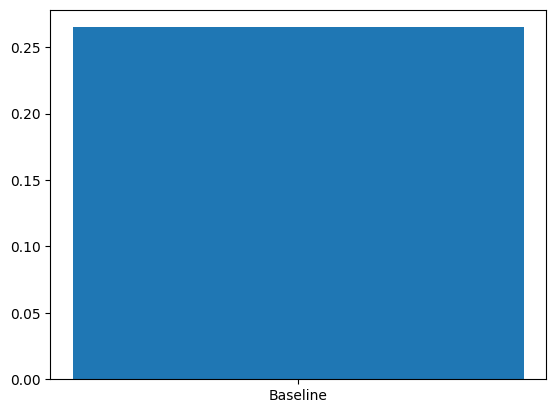

None


In [38]:
metrics = ['accuracy']

baseline_result = evaluate(model = untrained_model,
                           test_dataloader = test_dataloader,
                           device = device,
                           metric_strs = metrics)['accuracy']


#PLOT
results = [baseline_result]
names = ['Baseline']
print(make_plots(results, names))

### Baseline - Training the untrained model

In [39]:
def train(model: torch.nn.Module, optimizer: Optimizer, num_epochs: int,
          train_dataloader: DataLoader, validation_dataloader: DataLoader,
          lr_scheduler: Any, device: torch.device) -> None:
  """
  Trains a model by performing a forward pass and backpropating on batches to optimize loss.

  Parameters:
  -----------
  model : torch.nn.Module
      The model to be trained.
  optimizer : torch.optim.Optimizer
      The training optimizer.
  num_epochs : int
      Number of epochs to train for.
  train_dataloader : DataLoader
      DataLoader containing training examples.
  validation_dataloader : DataLoader
      DataLoader containing validation examples.
  lr_scheduler : Any
      Learning rate scheduler.
  device : torch.device
      The device that the training will be performed on.

  Returns:
  --------
  None
  """

  # CrossEntropyLoss - loss function
  loss_function = torch.nn.CrossEntropyLoss()

  for epoch in range(num_epochs):
    model.train()

    # load metrics
    metrics = [load_metric(x) for x in ["accuracy"]] # could add more here!

    print(f"Epoch {epoch + 1} training:")
    progress_bar = tqdm(range(len(train_dataloader)))

    for batch in train_dataloader:

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        loss = loss_function(logits, labels)

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
        lr_scheduler.step()

        predictions = torch.argmax(logits, dim=-1).detach()
        for metric in metrics:
            metric.add_batch(predictions=predictions, references=labels)

        progress_bar.update(1)

    # print the epoch's average metrics
    print(f"Epoch {epoch+1} average training metrics: accuracy={metrics[0].compute()['accuracy']}")

    # normally, validation would be more useful when training for many epochs
    print("Running validation:")

    val_metrics = evaluate(model, validation_dataloader, device, ["accuracy"])
    print(f"Epoch {epoch+1} validation: accuracy={val_metrics['accuracy']}")


In [40]:
# Training the model

from transformers import get_scheduler
from torch.optim import AdamW

num_epochs = 2

optimizer = AdamW(untrained_model.parameters(), lr=5e-5)

lr_scheduler = get_scheduler(
  "linear",
  optimizer=optimizer,
  num_warmup_steps=50,
  num_training_steps=len(train_dataloader) * num_epochs
)

torch.cuda.empty_cache()
untrained_model.to(device)

train(untrained_model,
      optimizer, num_epochs,
      train_dataloader,
      validation_dataloader,
      lr_scheduler,
      device)

Epoch 1 training:


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 1 average training metrics: accuracy=0.372
Running validation:


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1 validation: accuracy=0.399
Epoch 2 training:


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 2 average training metrics: accuracy=0.399
Running validation:


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2 validation: accuracy=0.449


  0%|          | 0/32 [00:00<?, ?it/s]

Baseline accuracy: 0.265
Manually Trained accuracy: 0.455


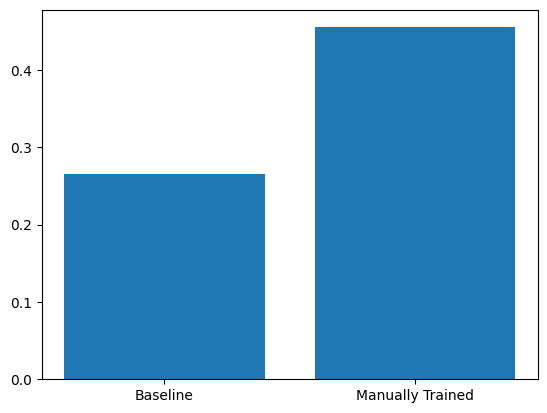

In [41]:
# Evaluate

metrics = ['accuracy']

# Evaluate on test dataset!
trained_result = evaluate(model=untrained_model,
    test_dataloader=test_dataloader,
    device=device,
    metric_strs=["accuracy"])['accuracy']

# Plot
results = baseline_result, trained_result
names = ['Baseline', 'Manually Trained']
make_plots(results, names)

### Fine-tuning pre-trained model

In [42]:
# Load pre-trained model

from transformers import DistilBertForSequenceClassification

pretrained_model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased" , num_labels = 3
)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/32 [00:00<?, ?it/s]

Baseline accuracy: 0.265
Manually trained accuracy: 0.455
Pre-trained accuracy: 0.255


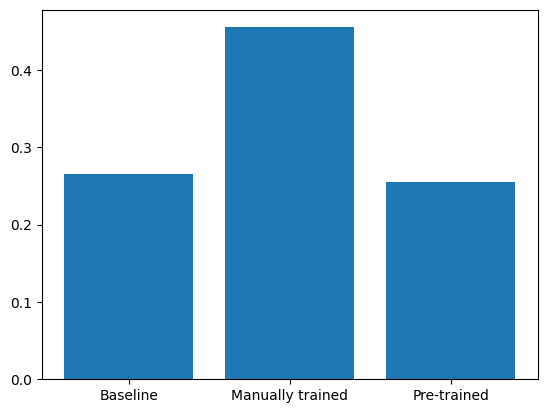

In [43]:
pretrained_model.to(device)

pretrained_result = evaluate(
    model=pretrained_model,
    test_dataloader=test_dataloader,
    device=device,
    metric_strs=["accuracy"]
)['accuracy']

#Plot
results = [baseline_result, trained_result, pretrained_result]
names = ['Baseline', 'Manually trained', 'Pre-trained']
make_plots(results, names)

Rather than train the model from scratch, we'll now fine-tune the pre-trained model! That is, we will take the model that was trained to predict masked words,
and now train it on our sentiment analysis task.
We'll fine-tune by simply running the `train` function on our pre-trained model with the training data! Fine-tune it for **2 epochs**.

In [44]:
num_epochs = 2

optimizer = AdamW(pretrained_model.parameters(), lr=5e-5)

lr_scheduler = get_scheduler(
  "linear",
  optimizer=optimizer,
  num_warmup_steps=50,
  num_training_steps=len(train_dataloader) * num_epochs
)

torch.cuda.empty_cache()
pretrained_model.to(device)

#Training
train(pretrained_model,
      optimizer,
      num_epochs,
      train_dataloader,
      validation_dataloader,
      lr_scheduler,
      device)

Epoch 1 training:


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 1 average training metrics: accuracy=0.532
Running validation:


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1 validation: accuracy=0.667
Epoch 2 training:


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 2 average training metrics: accuracy=0.6993333333333334
Running validation:


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2 validation: accuracy=0.671


  0%|          | 0/32 [00:00<?, ?it/s]

Baseline accuracy: 0.423
Manually trained accuracy: 0.565
Pre-trained accuracy: 0.353
Fine-tuned accuracy: 0.755


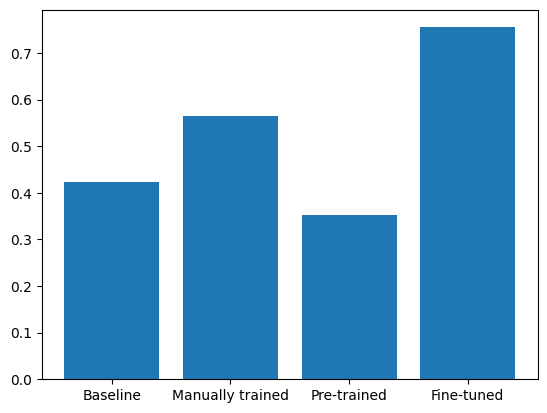

In [ ]:
# Evaluating the fine-tuned model

finetuned_result = evaluate(
    model = pretrained_model,
    test_dataloader = test_dataloader,
    device = device,
    metric_strs = ['accuracy']
)['accuracy']

#Plot
results = [baseline_result, trained_result, pretrained_result, finetuned_result]
names = ['Baseline', 'Manually trained', 'Pre-trained', 'Fine-tuned']
make_plots(results, names)

With just two epochs of training, and only 3k training examples, we can achieve ~75% accuracy

As we can see, the pre-trained model has a very noticeable advantage over the completely untrained one. Training for an additional epoch renders a slight improvement, afterwhich the fine-tuning begins to overfit on our training set, which can be judged by comparing the average epoch training accuracies and validation accuracies.